# MLP Lesson 1

## Google Cloud Storage Boilerplate

This first cell has some boilerplate to connect the Google Cloud Storage bucket containing the data used for this tutorial to the Google Colab environment. 

In order to access the data for this workshop you'll need to run this cell, follow the link when prompted and copy the Google SDK token into the prompt. If everything works correctly a new folder called `data` should appear in the file browser on the left.

In [1]:
%tensorflow_version 2.x
from google.colab import auth
auth.authenticate_user()

project_id = 'sciml-workshop'
bucket_name = 'sciml-workshop'

!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse

!gcloud config set project {project_id}

!mkdir data
!gcsfuse  --implicit-dirs --limit-bytes-per-sec -1 --limit-ops-per-sec -1 {bucket_name} /content/data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   653  100   653    0     0   8592      0 --:--:-- --:--:-- --:--:--  8592
OK
58 packages can be upgraded. Run 'apt list --upgradable' to see them.
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 58 not upgraded.
Need to get 4,274 kB of archives.
After this operation, 12.8 MB of additional disk space will be used.
Selecting previously unselected package gcsfuse.
(Reading database ... 144467 files and directories currently installed.)
Preparing to unpack .../gcsfuse_0.28.1_amd64.deb ...
Unpacking gcsfuse (0.28.1) ...
Setting up gcsfuse (0.28.1) ...
Updated property [core/project].
Using mount point: /content/data
Opening GCS connection...
Opening bucket...
Mounting file system...
File system has been successfully mounted.


In [0]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from numpy.random import seed
import tensorflow as tf
seed(1)
tf.random.set_seed(2)
plt.style.use('ggplot')

# Multi layer perceptron

In this practical we fit our first deep neural network. We are starting with the simplest architecture - a multi-layer perceptron (MLP). 

## The task

We have a set of spectra from Muon spectroscopy experiemnts, we would like to train a NN to be able to detect from a given spectrum wheter or not a certain element is present in the sample. In this case we are going to try to train a network to detect if there is `Ag` in a sample.

## The data

There is a dataset conveniently provided with spectra and labels saying wheter or not there is `Ag` in the data (`ag-muon-data.pkl`). It is in a `pickle` file, load it into a `pandas` dataframe and take a quick look.

In [0]:
df = pd.read_pickle('/content/data/muon/ag-muon-data.pkl')

In [4]:
df.head()

,0,1,2,3
0,[Zn],0,"[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2...","[0.0, 0.0, 181.8778921374784, 488.349654519592..."
1,"[Sb, Zn, Si]",0,"[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2...","[0.0, 0.0, 202.97108056052195, 433.59971962403..."
2,"[Fe, Sb]",0,"[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2...","[0.0, 0.0, 212.7229415490735, 428.816091507503..."
3,"[Ag, Zn, Cu, Sb]",1,"[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2...","[0.0, 0.0, 192.36172506402616, 420.19496785125..."
4,"[Fe, Zn]",0,"[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2...","[0.0, 0.0, 206.91647977543502, 434.03768636007..."


Notice that the third column of the dataframe contains either 1 or zero, conveniently the data has already been one-hot-encoded for you. 1 - there is `Ag` in the sample, 0 - there is no `Ag` in the sample. The fifth column of the dataframe contains the spectroscopic signal from the experiment. 

The sample number `23993` is pure `Ag` plot it out to see the kind of data we are looking at.

*Note* To access this data in `pandas` use `sample = df.iloc[23993][3]`

In [0]:
sample = df.iloc[23993][3]

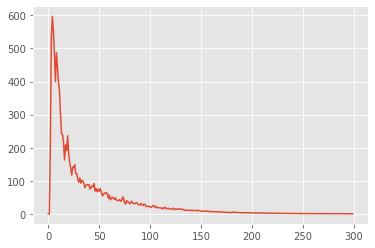

In [6]:
plt.plot(sample)

We can see some clear peaks associated with `Ag` - however, to get a feel for the complexity of picking out signals with `Ag` in multinary samples try plotting sample number `26`, which is an `Ag/Si` binary.

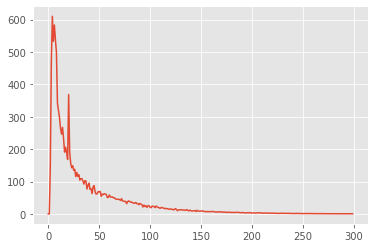

In [7]:
sample = df.iloc[26][3]
plt.plot(sample)

## The approach

We are going to try and train a NN to classify spectra into those that contain `Ag` and those that do not.

Get X - your input data as the fifth column of the dataset and y your objective as the third column. You can use the pandas function `to_list` to do this. Convert the resulting lists to `numpy` arrays for feeding to the NN.

In [0]:
X = np.array(df[3].to_list())
y = np.array(df[1].to_list())

## Try out a network

We can see that the data is given as a series of 300 points, each corresponding to an intensity. We can think about building a MLP that has 300 nodes in the input layer and then a single node in the output layer. The output should be 1 if there is `Ag` in the sample and 0 if there is no `Ag` in the sample.

We will start by using `keras` `Sequential` model building - this allows you to simply add new layers to a model using the `model.add(<layer details>)` command. The model is instantiated with
```
model = Sequential()
```
Now we want to add layers to the netowrk - as we are building a MLP, all of our layers are fully connected or [`Dense`](https://keras.io/layers/core/) layers. The arguments that are passed to the dense layer are
* Number of nodes
* Number of inputs to the layer - this is only necessary for the first layer and must match the shape of the data
* Activation function - this is the non-linear function used to calculate the activation of the layer 
* There are many other properties you can set, but these are all we need for now

**Note** we are importing from `tensorflow.keras`, rather than `keras` this is to ensure consistency with models built in pure `tensorflow`.

In [0]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
# define the keras model
model = Sequential()
model.add(Dense(12, input_dim=300, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

We can now look at the properties of the model with `model.summary()`

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12)                3612      
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 3,725
Trainable params: 3,725
Non-trainable params: 0
_________________________________________________________________


Now you need to [compile](https://keras.io/models/model/) the model - this involves setting a `loss` to train against, an `optimizer` and optionally some `metrics` to evaluate during the training. For the `loss`, since we are fitting to a range between 0 and 1 `binary_crossentropy` is the obvious choice. For `optimizer` we use `adam` and we will have just one metric `accuracy` - note that metrics must be passed as a list. See the [`keras` documentation](https://keras.io/models/model/)

In [0]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

When the model is compied we can now start to fit it using the data. Again details of the `fit` function of `keras` models can be found in the [`keras` documentation](https://keras.io/models/model/). 

We need to specify the X and y data, we will run for 60 epochs and we will use a batch size of 32. We should also specify a validation split of 20% of the data using `validation_split=0.2` Run the model for `5` epochs with a `batch_size` of 64.

In [12]:
model.fit(X, y, epochs=5, batch_size=64, validation_split=0.2)

Epoch 1/5
2800/2800 [==============================] - 7s 2ms/step - loss: 0.2339 - accuracy: 0.9515 - val_loss: 0.0554 - val_accuracy: 1.0000
Epoch 2/5
2800/2800 [==============================] - 6s 2ms/step - loss: 0.1935 - accuracy: 0.9519 - val_loss: 0.0688 - val_accuracy: 1.0000
Epoch 3/5
2800/2800 [==============================] - 6s 2ms/step - loss: 0.1929 - accuracy: 0.9519 - val_loss: 0.0454 - val_accuracy: 1.0000
Epoch 4/5
2800/2800 [==============================] - 6s 2ms/step - loss: 0.1921 - accuracy: 0.9519 - val_loss: 0.0416 - val_accuracy: 1.0000
Epoch 5/5
2800/2800 [==============================] - 7s 2ms/step - loss: 0.1905 - accuracy: 0.9519 - val_loss: 0.0412 - val_accuracy: 1.0000


## Class imbalance

Notice how the accuracy of the model very quickly achieves a certain value and then stops improving. This value could be well above 50%, which suggests that that model is actually learning something. However we may have fallen into a trap here. Take a look at the distribution of the target data, using `plt.hist(y)`. Also pay special attention to the validation data (the final 20% of the data).

(array([201927.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,   1073.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

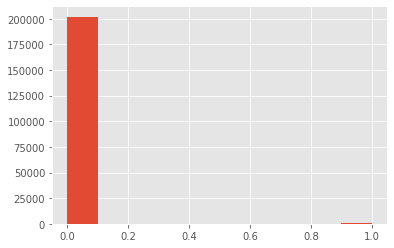

In [13]:
plt.hist(y[21000:])

We can check how the model performs on a more balanced set of data, which has 50:50 `Ag`/`no Ag` split.
* Load the test set data (`xtest`) and corresponding labels (`ytest`)
* Create an array of predicted values by running the `model.predict()` on `xtest`
* Use the function `accuracy_score(y_pred, ytest)` to see how well the model really does

In [14]:
with open('data/muon/test_spectra.pkl', 'rb') as handle:
  xtest = pickle.load(handle)

with open('data/muon/test_labels.pkl', 'rb') as handle:
  ytest = pickle.load(handle)

y_pred = model.predict(xtest)
accuracy_score(ytest, y_pred > .5)

0.5

You might notice something about the class numbers that closely resembls the accuracy achieved by the model. The data with no `Ag` accounts for around 95% of the data. So if the model simply learns to guess no `Ag` it can achieve 95% accuracy without learning anything useful. To avoid this we will rebalabace the classes. This is known as the accuracy paradox.

With class imbalance there are a number  of strategies that you can take to address the problem.

* Up-sample the minority class
* Down-sample the majority class
* Change your performance metric

In our case the best available option is to down-sample the majority class, so that `Ag` and no`Ag` have equal numbers in the datasets.

You can split the dataframe into the `1` and `0` entries using something like `df[df[1]==0]`.

Then use [`sklearn.utils.resample`](https://scikit-learn.org/stable/modules/generated/sklearn.utils.resample.html) to resample the majority dataframe.

Then concatenate and shuffle the datasets - `pd.concat` followed by `pd.sample`

A good online guide is available [here](https://elitedatascience.com/imbalanced-classes).

In [0]:
from sklearn.utils import resample

num_ag = np.count_nonzero(y==0)
num_no_ag = np.count_nonzero(y==1)

df_majority = df[df[1]==0]
df_minority = df[df[1]==1]

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=num_no_ag,     # to match minority class
                                 random_state=123) # reproducible results

df_downsampled = pd.concat([df_majority_downsampled, df_minority])
df_new = df_downsampled.sample(frac=1)

X = np.array(df_new[3].to_list())
y = np.array(df_new[1].to_list())

In [16]:
model.fit(X, y, epochs=5, batch_size=64, validation_split=0.2)

Epoch 1/5
216/216 [==============================] - 1s 4ms/step - loss: 0.7105 - accuracy: 0.4966 - val_loss: 0.6934 - val_accuracy: 0.5138
Epoch 2/5
216/216 [==============================] - 1s 3ms/step - loss: 0.6942 - accuracy: 0.4966 - val_loss: 0.6928 - val_accuracy: 0.5138
Epoch 3/5
216/216 [==============================] - 1s 3ms/step - loss: 0.6933 - accuracy: 0.4966 - val_loss: 0.6931 - val_accuracy: 0.5138
Epoch 4/5
216/216 [==============================] - 1s 3ms/step - loss: 0.6932 - accuracy: 0.4963 - val_loss: 0.6932 - val_accuracy: 0.4862
Epoch 5/5
216/216 [==============================] - 1s 3ms/step - loss: 0.6932 - accuracy: 0.5013 - val_loss: 0.6932 - val_accuracy: 0.4862


**Note** In some instances the model now stops learning at around 50% - pretty disappointing. So what else could be holding us back? In some instances the model will actually train and achieve above 50% in this step - the explanation is below.

## Optimizer hyperparameters

Recall from the lecture that we talked about hyperparameters in optimizers. In this case we have used the `Adam` optimizer with a default learning rate. 

> "The learning rate is perhaps the most important hyperparameter. If you have time to tune only one hyperparameter, tune the learning rate." - Goodfellow, Deep Learning

One thing that can happen if our learning rate is too high initially is that the optimizer can continually jump over optimal solutions and not actually find its way to a good answer. Whether or not the optimizer does find it's way to a minmum is down to a combination of the loss function space, the starting parameters and the optimizer settings. Since the initial parameters of the network are randomised there are some cases, as noted above where, the network will optimise at the standard learning rate. However, sometimes it will just keep skipping around and not learning. 

To overcome this problem we can lower the learning rate of the optimizer for an initial optimisation. Once the model has started to train and the loss has started to decrease we can dial the learning rate back up to speed up the training.

On the other hand, lower the learning rate too much and training will take an eternity.

### Grid search for learning rate

For this part of the exercise we will do a serach over possible learning rates. Typically we would look over  range of 0.1 to 10$^{-5}$ on a $\log$ scale.

To edit the optimizer settings, we import the optimizer `Adam` from `tensorflow.keras.optimizers` and set the learning rate

```
ad = Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy', optimizer=ad, metrics=['accuracy'])
```

Construct a loop to go over the learning rate range described above. For each training cycle we will extract the best validation accuracy value.

You can save the history of a training cycle as a dictionary simply by `history = model.fit(<params>)`, here the metrics and losses are saved to a dictionary `history.history`. Run the model for 40 epochs at each learning rate.

Save this dictionary for each learning rate and then compare the results. Look at maximum value for `accuracy` from each of the learning rates.

In [17]:
from tensorflow.keras.optimizers import Adam
lr_histories = []
for lr in [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]:
    model = Sequential()
    model.add(Dense(12, input_dim=300, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    ad = Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(loss='binary_crossentropy', optimizer=ad, metrics=['accuracy'])
    history = model.fit(X, y, epochs=40, batch_size=64, validation_split=0.2)
    lr_histories.append(history.history)

Epoch 1/40
216/216 [==============================] - 1s 4ms/step - loss: 6.7685 - accuracy: 0.4968 - val_loss: 0.6928 - val_accuracy: 0.5138
Epoch 2/40
216/216 [==============================] - 1s 4ms/step - loss: 0.6938 - accuracy: 0.4984 - val_loss: 0.6953 - val_accuracy: 0.4862
Epoch 3/40
216/216 [==============================] - 1s 3ms/step - loss: 0.6947 - accuracy: 0.4942 - val_loss: 0.6928 - val_accuracy: 0.5138
Epoch 4/40
216/216 [==============================] - 1s 3ms/step - loss: 0.6943 - accuracy: 0.5053 - val_loss: 0.6956 - val_accuracy: 0.4862
Epoch 5/40
216/216 [==============================] - 1s 3ms/step - loss: 0.6942 - accuracy: 0.5032 - val_loss: 0.6995 - val_accuracy: 0.4862
Epoch 6/40
216/216 [==============================] - 1s 3ms/step - loss: 0.6943 - accuracy: 0.5040 - val_loss: 0.6938 - val_accuracy: 0.4862
Epoch 7/40
216/216 [==============================] - 1s 3ms/step - loss: 0.6943 - accuracy: 0.4982 - val_loss: 0.6985 - val_accuracy: 0.4862
Epoch 

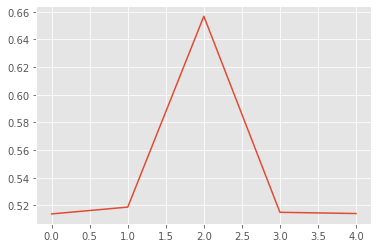

In [18]:
maxs = [max(h['val_accuracy']) for h in lr_histories]
plt.plot(maxs)

### Now train the model at the identified learning rate for 100 epochs

The `val_acc` tops out at learning rate $10^{-3}$ or $10^{-4}$. Remember there is some randomness in how the data is split and shuffled and in the initialisation of paremeters, hence it can be one of two values. Regardless, we will take the mean of these two as the learning rate for training the model for a longer time. 100 epochs.

Then plot the training history of this run - again taken from the `history.history` dictionary.

In [19]:
# define the keras model
from tensorflow.keras.optimizers import Adam
model = Sequential()
model.add(Dense(12, input_dim=300, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
ad = Adam(learning_rate=5e-4, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='binary_crossentropy', optimizer=ad, metrics=['accuracy'])
history = model.fit(X, y, epochs=100, batch_size=64, validation_split=0.2)

Epoch 1/100
216/216 [==============================] - 1s 3ms/step - loss: 0.8115 - accuracy: 0.4908 - val_loss: 0.7203 - val_accuracy: 0.4935
Epoch 2/100
216/216 [==============================] - 1s 3ms/step - loss: 0.7128 - accuracy: 0.5092 - val_loss: 0.7021 - val_accuracy: 0.5178
Epoch 3/100
216/216 [==============================] - 1s 3ms/step - loss: 0.7025 - accuracy: 0.5161 - val_loss: 0.7033 - val_accuracy: 0.5149
Epoch 4/100
216/216 [==============================] - 1s 3ms/step - loss: 0.6969 - accuracy: 0.5226 - val_loss: 0.6909 - val_accuracy: 0.5352
Epoch 5/100
216/216 [==============================] - 1s 3ms/step - loss: 0.6944 - accuracy: 0.5248 - val_loss: 0.7053 - val_accuracy: 0.5132
Epoch 6/100
216/216 [==============================] - 1s 3ms/step - loss: 0.6910 - accuracy: 0.5342 - val_loss: 0.6860 - val_accuracy: 0.5457
Epoch 7/100
216/216 [==============================] - 1s 3ms/step - loss: 0.6901 - accuracy: 0.5427 - val_loss: 0.6885 - val_accuracy: 0.5361

0.668987512588501


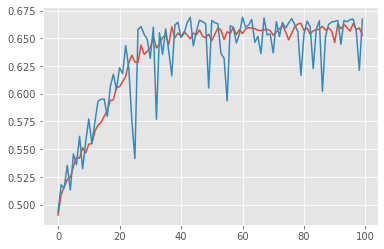

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
print(max(history.history['val_accuracy']))

## Speed up the learning

Even when we are using a slower learning rate, it is possible to speed up the training process. `BatchNormalization` is covered in the lectures and involves normalising all values going into a layer before the forward pass. Although it introduces some small extra computational cost into the forward pass, the results for speeding up learning rate can be spectacular - particularly in the deeper networks that we will look at in the next part of this exercise.

For now, import `BatchNormalization` from `tensorflow.keras.layers` and add a `BatchNormalization()` unit between each of your `Dense` layers.

Retrain the model and look at the learning rates.

In [21]:
# define the keras model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
model = Sequential()
model.add(Dense(12, input_dim=300, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(8, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))
ad = Adam(learning_rate=1e-4)
model.compile(loss='binary_crossentropy', optimizer=ad, metrics=['accuracy'])
history_bn = model.fit(X, y, epochs=100, batch_size=64, validation_split=0.2)

Epoch 1/100
216/216 [==============================] - 1s 4ms/step - loss: 0.8622 - accuracy: 0.4823 - val_loss: 0.8539 - val_accuracy: 0.4848
Epoch 2/100
216/216 [==============================] - 1s 4ms/step - loss: 0.7976 - accuracy: 0.4900 - val_loss: 0.7905 - val_accuracy: 0.4912
Epoch 3/100
216/216 [==============================] - 1s 4ms/step - loss: 0.7612 - accuracy: 0.4923 - val_loss: 0.7561 - val_accuracy: 0.4987
Epoch 4/100
216/216 [==============================] - 1s 4ms/step - loss: 0.7351 - accuracy: 0.5032 - val_loss: 0.7330 - val_accuracy: 0.5091
Epoch 5/100
216/216 [==============================] - 1s 4ms/step - loss: 0.7190 - accuracy: 0.5169 - val_loss: 0.7204 - val_accuracy: 0.5196
Epoch 6/100
216/216 [==============================] - 1s 4ms/step - loss: 0.7093 - accuracy: 0.5301 - val_loss: 0.7111 - val_accuracy: 0.5257
Epoch 7/100
216/216 [==============================] - 1s 4ms/step - loss: 0.7024 - accuracy: 0.5338 - val_loss: 0.7042 - val_accuracy: 0.5309

0.6628952622413635


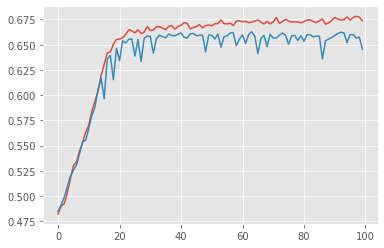

In [22]:
plt.plot(history_bn.history['accuracy'])
plt.plot(history_bn.history['val_accuracy'])
print(max(history_bn.history['val_accuracy']))

## Look at some other metrics

Lets look at some other metrics of model performance. Let's try a confusion matrix. Start getting your true and predicted y values, then use `sklearn.metrics.confusion_matrix` to build the confusion matrix.

The confusion matrix returned by `scikit-learn` has the following form:

$$
\begin{bmatrix}
TP & FP \\
FN & TN \\ 
\end{bmatrix}
$$

Where:
 - TP: True Positives
 - FP: False Positives
 - FN: False Negatives
 - TN: True Negatives

This matrix can indicate when the model is going wrong and can help to debug point problems with the network.

In [0]:
y_true = y
y_pred = model.predict(X)

In [24]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

y_pred = np.rint(y_pred)
confusion_matrix(y_true, y_pred)

array([[4876, 3741],
       [1979, 6638]])

### Extension Exercise

If you completed this notebook then you have a model that can predict around 67% accuracy. There's certaintly room for improvement! What changes do you think you can make to the network architecture to imporve the result? What's the best accuracy you can find?